<a href="https://colab.research.google.com/github/MengOonLee/BertelsmannAITrack/blob/MyLoveSong/LoveSongGenerator.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Love song generator!

In [0]:
# First let's load in our required resources for data loading and model creation.
import numpy as np
import torch
from torch import nn
import torch.nn.functional as F

import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = "retina"

In [0]:
# Then, we'll download the LoveSongs.txt and convert it into integers for our network to use.
%%bash

wget -qO LoveSongs.txt --no-check-certificate 'https://docs.google.com/uc?export=download&id=1-B1H4krto65n8hA3Qmm2UZ0_TZO2JE3t'

In [3]:
# open text file and read in data as `text`
with open('LoveSongs.txt', 'r') as f:
    text = f.read()

# Let's check out the first 100 characters, make sure everything is peachy.
text[:100]

"Doesn't take much to make me happy\nAnd make me smile with glee \nNever never will I feel discouraged "

In [4]:
# encode the text and map each character to an integer and vice versa

# we create two dictionaries:
# 1. int2char, which maps integers to characters
# 2. char2int, which maps characters to unique integers
chars = tuple(set(text))
int2char = dict(enumerate(chars))
char2int = {ch: ii for ii, ch in int2char.items()}

# encode the text
encoded = np.array([char2int[ch] for ch in text])

encoded[:100]

array([46, 65, 54,  5, 82, 44, 96, 12, 96, 28, 23, 54, 12, 30, 13, 48,  3,
       12, 96, 65, 12, 30, 28, 23, 54, 12, 30, 54, 12,  3, 28,  0,  0, 75,
       61, 22, 82, 71, 12, 30, 28, 23, 54, 12, 30, 54, 12,  5, 30, 39,  6,
       54, 12,  4, 39, 96,  3, 12, 74,  6, 54, 54, 12, 61, 31, 54, 24, 54,
        1, 12, 82, 54, 24, 54,  1, 12,  4, 39,  6,  6, 12, 62, 12, 37, 54,
       54,  6, 12, 71, 39,  5, 48, 65, 13,  1, 28, 74, 54, 71, 12])

In [0]:
def one_hot_encode(arr, n_labels):
    
    # Initialize the the encoded array
    one_hot = np.zeros((arr.size, n_labels), dtype=np.float32)
    
    # Fill the appropriate elements with ones
    one_hot[np.arange(one_hot.shape[0]), arr.flatten()] = 1.
    
    # Finally reshape it to get back to the original array
    one_hot = one_hot.reshape((*arr.shape, n_labels))
    
    return one_hot

In [0]:
def get_batches(arr, batch_size, seq_length):
    '''Create a generator that returns batches of size
       batch_size x seq_length from arr.
       
       Arguments
       ---------
       arr: Array you want to make batches from
       batch_size: Batch size, the number of sequences per batch
       seq_length: Number of encoded chars in a sequence
    '''
    
    batch_size_total = batch_size * seq_length
    ## Get the number of batches we can make
    n_batches = len(arr)//batch_size_total
    
    ## Keep only enough characters to make full batches
    arr = arr[:n_batches * batch_size_total]
    
    ## Reshape into batch_size rows
    arr = arr.reshape((batch_size, -1))
    
    ## Iterate over the batches using a window of size seq_length
    for n in range(0, arr.shape[1], seq_length):
        # The features
        x = arr[:, n:n+seq_length]
        # The targets, shifted by one
        y = np.zeros_like(x)
        try:
            y[:, :-1], y[:, -1] = x[:, 1:], arr[:, n+seq_length]
        except IndexError:
            y[:, :-1], y[:, -1] = x[:, 1:], arr[:, 0]
        yield x, y

In [7]:
# check if GPU is available
train_on_gpu = torch.cuda.is_available()
if(train_on_gpu):
    print('Training on GPU!')
else: 
    print('No GPU available, training on CPU; consider making n_epochs very small.')

Training on GPU!


In [0]:
class CharRNN(nn.Module):
    
    def __init__(self, tokens, n_hidden=256, n_layers=2,
                               drop_prob=0.5, lr=0.001):
        super().__init__()
        self.drop_prob = drop_prob
        self.n_layers = n_layers
        self.n_hidden = n_hidden
        self.lr = lr
        
        # creating character dictionaries
        self.chars = tokens
        self.int2char = dict(enumerate(self.chars))
        self.char2int = {ch: ii for ii, ch in self.int2char.items()}
        
        ## define the layers of the model
        ## define the LSTM
        self.lstm = nn.LSTM(len(self.chars), n_hidden, n_layers, 
                            dropout=drop_prob, batch_first=True)
        
        ## define a dropout layer
        self.dropout = nn.Dropout(drop_prob)
        
        ## define the final, fully-connected output layer
        self.fc = nn.Linear(n_hidden, len(self.chars))
    
    def forward(self, x, hidden):
        ''' Forward pass through the network. 
            These inputs are x, and the hidden/cell state `hidden`. '''
                
        ## Get the outputs and the new hidden state from the lstm
        r_output, hidden = self.lstm(x, hidden)

        ## pass through a dropout layer
        out = self.dropout(r_output)
        
        # Stack up LSTM outputs using view
        # you may need to use contiguous to reshape the output
        out = out.contiguous().view(-1, self.n_hidden)
        
        ## put x through the fully-connected layer
        out = self.fc(out)
        
        # return the final output and the hidden state
        return out, hidden
    
    
    def init_hidden(self, batch_size):
        ''' Initializes hidden state '''
        # Create two new tensors with sizes n_layers x batch_size x n_hidden,
        # initialized to zero, for hidden state and cell state of LSTM
        weight = next(self.parameters()).data
        
        if (train_on_gpu):
            hidden = (weight.new(self.n_layers, batch_size, self.n_hidden).zero_().cuda(),
                  weight.new(self.n_layers, batch_size, self.n_hidden).zero_().cuda())
        else:
            hidden = (weight.new(self.n_layers, batch_size, self.n_hidden).zero_(),
                      weight.new(self.n_layers, batch_size, self.n_hidden).zero_())
        
        return hidden

In [0]:
def train(net, data, epochs=10, batch_size=10, seq_length=50, lr=0.001, clip=5, val_frac=0.1, print_every=10):
    ''' Training a network 
    
        Arguments
        ---------
        
        net: CharRNN network
        data: text data to train the network
        epochs: Number of epochs to train
        batch_size: Number of mini-sequences per mini-batch, aka batch size
        seq_length: Number of character steps per mini-batch
        lr: learning rate
        clip: gradient clipping
        val_frac: Fraction of data to hold out for validation
        print_every: Number of steps for printing training and validation loss
    
    '''

    step_plot, train_loss_plot, val_loss_plot = [], [], []
    val_loss_min = np.Inf # save best model with the lowest validation loss

    net.train()
    
    opt = torch.optim.Adam(net.parameters(), lr=lr)
    criterion = nn.CrossEntropyLoss()
    
    # create training and validation data
    val_idx = int(len(data)*(1-val_frac))
    data, val_data = data[:val_idx], data[val_idx:]
    
    if(train_on_gpu):
        net.cuda()
    
    counter = 0
    n_chars = len(net.chars)
    for e in range(epochs):
        # initialize hidden state
        h = net.init_hidden(batch_size)
        
        for x, y in get_batches(data, batch_size, seq_length):
            counter += 1
            
            # One-hot encode our data and make them Torch tensors
            x = one_hot_encode(x, n_chars)
            inputs, targets = torch.from_numpy(x), torch.from_numpy(y)
            
            if(train_on_gpu):
                inputs, targets = inputs.cuda(), targets.cuda()

            # Creating new variables for the hidden state, otherwise
            # we'd backprop through the entire training history
            h = tuple([each.data for each in h])

            # zero accumulated gradients
            net.zero_grad()
            
            # get the output from the model
            output, h = net(inputs, h)
            
            # calculate the loss and perform backprop
            loss = criterion(output, targets.view(batch_size*seq_length).long())
            loss.backward()
            # `clip_grad_norm` helps prevent the exploding gradient problem in RNNs / LSTMs.
            nn.utils.clip_grad_norm_(net.parameters(), clip)
            opt.step()
            
            # loss stats
            if counter % print_every == 0:
                # Get validation loss
                val_h = net.init_hidden(batch_size)
                val_losses = []
                net.eval()
                for x, y in get_batches(val_data, batch_size, seq_length):
                    # One-hot encode our data and make them Torch tensors
                    x = one_hot_encode(x, n_chars)
                    x, y = torch.from_numpy(x), torch.from_numpy(y)
                    
                    # Creating new variables for the hidden state, otherwise
                    # we'd backprop through the entire training history
                    val_h = tuple([each.data for each in val_h])
                    
                    inputs, targets = x, y
                    if(train_on_gpu):
                        inputs, targets = inputs.cuda(), targets.cuda()

                    output, val_h = net(inputs, val_h)
                    val_loss = criterion(output, targets.view(batch_size*seq_length).long())
                
                    val_losses.append(val_loss.item())
                
                net.train() # reset to train mode after iterationg through validation data
                
                print("Epoch: {}/{}...".format(e+1, epochs),
                      "Step: {}...".format(counter),
                      "Loss: {:.4f}...".format(loss.item()),
                      "Val Loss: {:.4f}".format(np.mean(val_losses)))
                
                if np.mean(val_losses) <= val_loss_min:
                  val_loss_min = np.mean(val_losses)
                  print("Val loss decreased. Save model.")
                  # Save model
                  model_name = 'LoveSongGenerator.net'

                  checkpoint = {'n_hidden': net.n_hidden,
                                'n_layers': net.n_layers,
                                'state_dict': net.state_dict(),
                                'tokens': net.chars}

                  with open(model_name, 'wb') as f:
                      torch.save(checkpoint, f)
                
                # append result for plotting
                step_plot.append(counter)
                train_loss_plot.append(loss.item())
                val_loss_plot.append(np.mean(val_losses))

    # visualize our train loss and valid loss
    plt.plot(step_plot, train_loss_plot, 'r--', label="Training loss")
    plt.plot(step_plot, val_loss_plot, 'b-', label="Validation loss")
    plt.legend(frameon=False)
    plt.xlabel('Step')
    plt.ylabel('Loss')
    plt.show()

In [10]:
## et your model hyperparameters
# define and print the net
n_hidden=512
n_layers=3

net = CharRNN(chars, n_hidden, n_layers)
print(net)

CharRNN(
  (lstm): LSTM(99, 512, num_layers=3, batch_first=True, dropout=0.5)
  (dropout): Dropout(p=0.5, inplace=False)
  (fc): Linear(in_features=512, out_features=99, bias=True)
)


Epoch: 1/30... Step: 10... Loss: 3.2649... Val Loss: 3.2395
Val loss decreased. Save model.
Epoch: 1/30... Step: 20... Loss: 3.2063... Val Loss: 3.2010
Val loss decreased. Save model.
Epoch: 1/30... Step: 30... Loss: 3.1767... Val Loss: 3.1982
Val loss decreased. Save model.
Epoch: 1/30... Step: 40... Loss: 3.1668... Val Loss: 3.1962
Val loss decreased. Save model.
Epoch: 1/30... Step: 50... Loss: 3.1382... Val Loss: 3.1965
Epoch: 1/30... Step: 60... Loss: 3.1623... Val Loss: 3.1962
Epoch: 2/30... Step: 70... Loss: 3.1492... Val Loss: 3.1944
Val loss decreased. Save model.
Epoch: 2/30... Step: 80... Loss: 3.1519... Val Loss: 3.1936
Val loss decreased. Save model.
Epoch: 2/30... Step: 90... Loss: 3.1411... Val Loss: 3.1936
Val loss decreased. Save model.
Epoch: 2/30... Step: 100... Loss: 3.1297... Val Loss: 3.1913
Val loss decreased. Save model.
Epoch: 2/30... Step: 110... Loss: 3.1385... Val Loss: 3.1868
Val loss decreased. Save model.
Epoch: 2/30... Step: 120... Loss: 3.0798... Val Lo

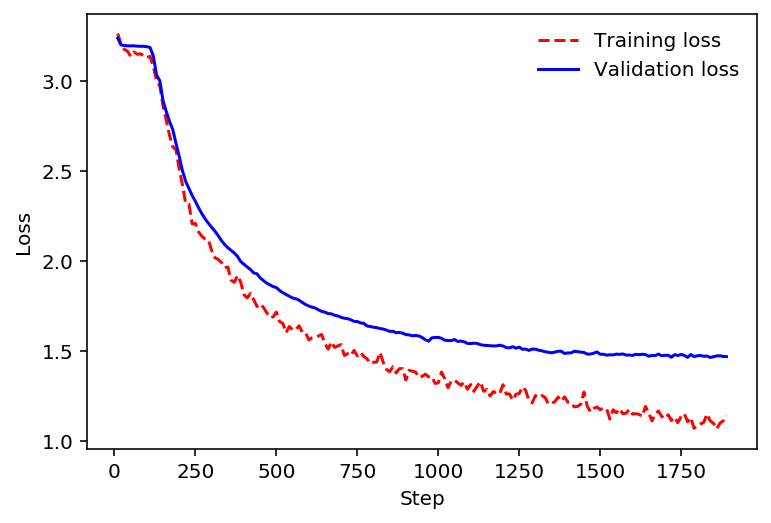

In [11]:
# Set your training hyperparameters!
batch_size = 128
seq_length = 100
n_epochs = 30 # start small if you are just testing initial behavior

# train the model
train(net, encoded, epochs=n_epochs, batch_size=batch_size, seq_length=seq_length, lr=0.001, print_every=10)

In [0]:
def predict(net, char, h=None, top_k=None):
        ''' Given a character, predict the next character.
            Returns the predicted character and the hidden state.
        '''
        
        # tensor inputs
        x = np.array([[net.char2int[char]]])
        x = one_hot_encode(x, len(net.chars))
        inputs = torch.from_numpy(x)
        
        if(train_on_gpu):
            inputs = inputs.cuda()
        
        # detach hidden state from history
        h = tuple([each.data for each in h])
        # get the output of the model
        out, h = net(inputs, h)

        # get the character probabilities
        p = F.softmax(out, dim=1).data
        if(train_on_gpu):
            p = p.cpu() # move to cpu
        
        # get top characters
        if top_k is None:
            top_ch = np.arange(len(net.chars))
        else:
            p, top_ch = p.topk(top_k)
            top_ch = top_ch.numpy().squeeze()
        
        # select the likely next character with some element of randomness
        p = p.numpy().squeeze()
        char = np.random.choice(top_ch, p=p/p.sum())
        
        # return the encoded value of the predicted char and the hidden state
        return net.int2char[char], h

In [0]:
def sample(net, size, prime='The', top_k=None):
        
    if(train_on_gpu):
        net.cuda()
    else:
        net.cpu()
    
    net.eval() # eval mode
    
    # First off, run through the prime characters
    chars = [ch for ch in prime]
    h = net.init_hidden(1)
    for ch in prime:
        char, h = predict(net, ch, h, top_k=top_k)

    chars.append(char)
    
    # Now pass in the previous character and get a new one
    for ii in range(size):
        char, h = predict(net, chars[-1], h, top_k=top_k)
        chars.append(char)

    return ''.join(chars)

In [14]:
# Here we have loaded in a model that trained
with open('LoveSongGenerator.net', 'rb') as f:
    checkpoint = torch.load(f)
    
loaded = CharRNN(checkpoint['tokens'], n_hidden=checkpoint['n_hidden'], n_layers=checkpoint['n_layers'])
loaded.load_state_dict(checkpoint['state_dict'])

print(sample(loaded, 2000, top_k=5, prime='Love'))

Love, I'm feeling so good 
I want to know
That I can see you to crazy for the sea
I know you would tell me 
To call on you, I wanna see you for the world 
We said that I've been to shine to me 
With a little hall falls and should be alright
And you say then I feel like that you do is true,
The same will be alone 
Without a look on a flame and the sky 
The whole way it we should be like a genely
I know, yeah
We will see you who when you say I could be with me

And we don't know what I can bring

You're the one that you are with me

You would be the one I kiss your love
That’s why, what I can see
I want to be the one, oh
If you'll be my soul fere
The moon is heart 
The start on the way I see your friends

I've been wrong
I know you sexy thing
I need you
I want to stay
I know I'll take you in my head,
You're the only one I can’t
Like to know it's true
I can't give, I look, to you

When they say is my soul

Something that you could so make me to be a beautiful

Tell me how much I'm with yo